In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


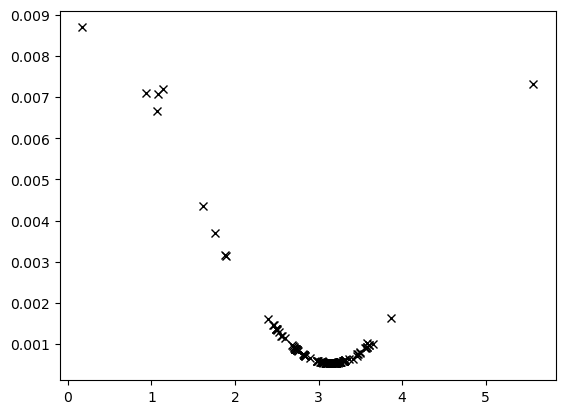

In [67]:
from SLoader import SLoader

S2 = SLoader(star="S2")

plt.plot(S2.phi, S2.u, 'kx')

[ -9.9 -33.7 -41.8 -47.6 -50.3 -63.3 -69.2 -71.2 -58.7 -67.  -52.4  -8.1
   4.   13.7  15.5  14.7  14.7  24.9  28.1  31.4  31.2  38.6  39.   38.3
  38.2  38.9  39.1  38.5  38.9  38.6  38.3  38.8  37.7  35.   34.7  33.9
  33.9  33.   33.2  33.4  33.1  32.2  32.2  31.5  31.9  31.1  31.8  26.
  25.1  24.7  24.7  24.3  23.5  23.   15.7   1.3   2.6   1.    0.4  -6.
  -6.5  -7.4  -9.7  -9.4  -9.  -10.  -11.8 -12.6 -18.4 -19.1 -19.6 -19.3
 -19.4 -19.5 -19.7 -20.9 -21.2 -21.9 -21.3 -22.3 -23.9 -24.1 -29.5 -29.6
 -29.  -29.3 -30.6 -31.8 -31.8 -31.4 -31.2 -31.3 -31.8 -33.9 -33.3 -33.2
 -33.5 -33.6 -34.2 -39.7 -39.7 -39.1 -39.5 -40.3 -38.9 -40.5 -40.4 -41.4
 -42.5 -42.7 -44.  -43.9 -42.8 -43.9 -44.1 -48.  -49.6 -50.1 -51.4 -51.1
 -51.7 -50.5 -51.7 -52.  -55.3 -55.5 -56.5 -56.7 -56.7 -56.  -57.3 -57.3
 -57.9 -57.3 -58.3 -66.2 -66.7 -67.  -66.8 -66.1 -66.  -66.  -66.2 -64.4
 -65.1]


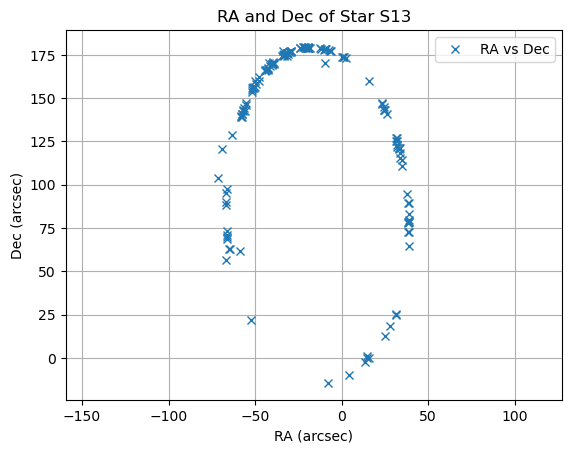

In [15]:
# oRA-S2,e_oRA-S2,oDE-S2,e_oDE-S2

# Step 1: Load the TSV data with the correct delimiter '|'
file_path = 'data/asu.csv'
df = pd.read_csv(file_path, sep=',')

# Step 2: Clean column names by stripping any extra spaces
df.columns = df.columns.str.strip()

# Step 9: Extract RA and Dec (ensure they are cleaned and converted to numeric)
x1 = pd.to_numeric(df['oRA-S2'].str.strip(), errors='coerce')  # RA (arcsec)
y1 = pd.to_numeric(df['oDE-S2'].str.strip(), errors='coerce')  # Dec (arcsec)

# Step 10: Drop rows where RA or Dec are NaN
cleaned_data = pd.DataFrame({'RA': x1, 'Dec': y1})
cleaned_data = cleaned_data.dropna()  # Drop rows with NaN values

print(x1.values[~np.isnan(x1.values)])
#print(x1.values)

# Step 11: Plot the data
fig, ax = plt.subplots()
ax.plot(cleaned_data['RA'], cleaned_data['Dec'], 'x', label='RA vs Dec')
ax.axis('equal')
ax.set_xlabel('RA (arcsec)')
ax.set_ylabel('Dec (arcsec)')
ax.set_title('RA and Dec of Star S13')
ax.grid(True)
plt.legend()
plt.show()

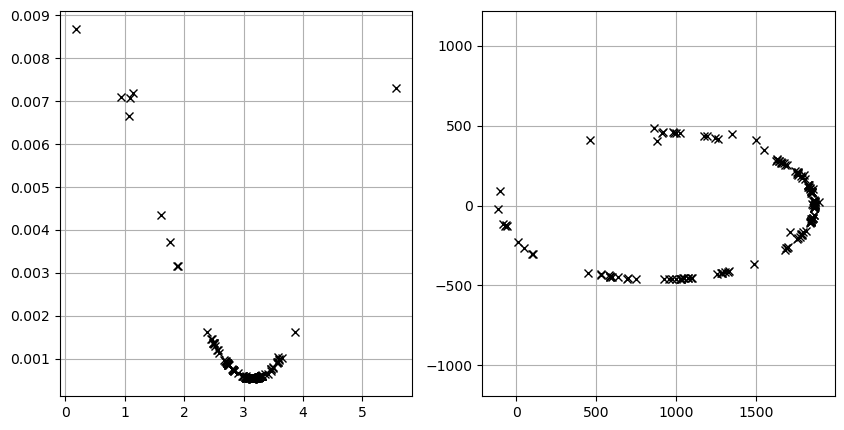

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np


class SLoader():
    def __init__(self, star="S2", file_path = 'data/asu.csv',
                 scaling=1e0, augment_data=False, std_data=False):
        # Actions to be done on the data during retrieval
        self.augment_data = augment_data
        self.std_data = std_data
        self.file_path = file_path
        self.star = star
        
        # 
        self.distance = 7900 # pc

        self.load_data()
        self.projection()
        self.y *= scaling 
        self.x *= scaling

        self.u = 1/np.sqrt(self.x**2 + self.y**2)
        phi = np.arccos(self.x*self.u) 
        self.phi = torch.where(self.y<0., -phi, phi).float()
        # self.phi[:len(y1)] += torch.pi * 2
        self.phi = torch.where(self.phi<0, self.phi+2*torch.pi, self.phi)
        self.phi = torch.where(self.phi>2.2*torch.pi, self.phi-2*torch.pi, self.phi)

        # self.u = torch.tensor(self.u, dtype=torch.float32)
        
    def load_data(self):
        """
        load_data:
            Loads data and error, and concatenates into tensors for x- and y-coordinates
        
        ARGS:
            * files :   List of files to load. 
        """
        df = pd.read_csv(file_path, sep=',')
        df.columns = df.columns.str.strip()

        try:
            x = pd.to_numeric(df['oRA-'+self.star].str.strip(), errors='coerce').values  # RA (arcsec)
            y = pd.to_numeric(df['oDE-'+self.star].str.strip(), errors='coerce').values  # Dec (arcsec)
            x_e = pd.to_numeric(df['e_oRA-'+self.star].str.strip(), errors='coerce').values  # RA (arcsec)
            y_e = pd.to_numeric(df['e_oDE-'+self.star].str.strip(), errors='coerce').values  # Dec (arcsec)
        except KeyError: 
            raise KeyError(f"{self.star} is not a registered star in the file {self.file_path}")

        # remove nans
        self.x = x[~np.isnan(x)]
        self.y = y[~np.isnan(y)]        
        self.x_e = x_e[~np.isnan(x_e)]
        self.y_e = y_e[~np.isnan(y_e)]

        # convert to tensor with correct shape
        self.x = torch.tensor(self.x).unsqueeze(1)
        self.y = torch.tensor(self.y).unsqueeze(1)
        self.x_e = torch.tensor(self.x_e).unsqueeze(1)
        self.y_e = torch.tensor(self.y_e).unsqueeze(1)


    def projection(self):
        """
        project:

        TODO: 
            * Project error

        """
        pc_to_au = 206265
        mas_to_rad = np.pi / (180 * 3600 * 1000)


        df = pd.read_csv("data/angles.csv", index_col=0)

        i = np.radians(df.loc[self.star, "i"])
        Ω = np.radians(df.loc[self.star, "Ω"])
        ω = np.radians(df.loc[self.star, "ω"])

        # Thiele-Innes elements
        A = np.cos(ω)*np.cos(Ω) - np.sin(ω)*np.sin(Ω)*np.cos(i)
        B = np.cos(ω)*np.sin(Ω) + np.sin(ω)*np.cos(Ω)*np.cos(i)
        F = -np.sin(ω)*np.cos(Ω) - np.cos(ω)*np.sin(Ω)*np.cos(i)
        G = -np.sin(ω)*np.sin(Ω) + np.cos(ω)*np.cos(Ω)*np.cos(i)

        # Transformation matrix (observer -> orbital plane)
        M_inv = np.array([[F, -G], [-A, B]]) / (B*F - A*G)

        X = self.x * mas_to_rad * self.distance * pc_to_au
        Y = self.y * mas_to_rad * self.distance * pc_to_au

        self.x = M_inv[0,0] * (X) + M_inv[0,1] * Y
        self.y = M_inv[1,0] * (X) + M_inv[1,1] * Y


    def __call__(self):
        phi = self.phi
        u = self.u

        if self.std_data:
            x_ = self.x + torch.normal(0, self.x_e)
            y_ = self.y + torch.normal(0, self.y_e)
            u = 1/torch.sqrt(x_**2 + y_**2)
            phi = np.arccos(x_*u) 
            phi = torch.where(y_<0., -phi, phi).float()
            phi = torch.where(phi<0, phi+2*torch.pi, phi)
            phi = torch.where(phi>2.2*torch.pi, phi-2*torch.pi, phi)

        if self.augment_data:
            phi = (phi + (torch.randint(low=0,high=3,size=phi.shape) - 1) * 2 * torch.pi)


        return torch.tensor(phi, dtype=torch.float32), torch.tensor(u, dtype=torch.float32) # norm const
    
    def __len__(self):
        return len(self.phi)
    
if __name__ == "__main__":
    d = SLoader(star="S2")

    x = d.x
    y = d.y    

    phi = d.phi
    u = d.u

    fig, ax = plt.subplots(figsize=(10,5), ncols=2)
    ax[0].plot(phi, u, 'kx')
    ax[0].grid()

    ax[1].plot(-x,-y,'kx')
    ax[1].grid()
    ax[1].axis('equal')
    plt.show()

In [ ]:
angles = {"S1": {"i": 119.14, "Ω": 342.04, "ω": 122.3},
          "S2": {"i": 134.18, "Ω": 226.94, "ω": 65.51},
          "S4": {"i": 80.33, "Ω": 258.84, "ω": 290.8},
          "S6": {"i": 87.24, "Ω": 85.07, "ω": 116.23},
          "S8": {"i": 74.37, "Ω": 315.43, "ω": 346.70},
          "S9": {"i": 82.41, "Ω": 156.6, "ω": 150.6},
          "S12": {"i": 33.56, "Ω": 230.1, "ω": 317.9},
          "S13": {"i": 24.70, "Ω": 74.5, "ω": 245.2},
          "S14": {"i": 100.59, "Ω": 226.38, "ω": 334.59},
          "S17": {"i": 96.83, "Ω": 191.62, "ω": 326.0},
          "S18": {"i": 110.67, "Ω": 49.11, "ω": 349.46},
          "S19": {"i": 71.96, "Ω": 344.60, "ω": 155.2},
          "S21": {"i": 58.8, "Ω": 259.64, "ω": 166.4},
          "S22": {"i": 105.76, "Ω": 291.7, "ω": 95},
          "S23": {"i": 48.0, "Ω": 249, "ω": 39.0},
          "S24": {"i": 103.67, "Ω": 7.93, "ω": 290},
          "S29": {"i": 105.8, "Ω": 161.96, "ω": 346.5},
          "S31": {"i": 109.03, "Ω": 137.16, "ω": 308.0},
          "S33": {"i": 60.5, "Ω": 100.1, "ω": 303.7},
          "S38": {"i": 171.1, "Ω": 101.06, "ω": 17.99},
          "S39": {"i": 89.36, "Ω": 159.03, "ω": 23.3},
          "S42": {"i": 67.16, "Ω": 196.14, "ω": 35.8},
          "S54": {"i": 62.2, "Ω": 288.35, "ω": 140.8},
          "S55": {"i": 150.1, "Ω": 325.5, "ω": 331.5},
          "S60": {"i": 126.87, "Ω": 170.54, "ω": 29.37},
          "S66": {"i": 128.5, "Ω": 92.3, "ω": 134},
          "S67": {"i": 136.0, "Ω": 96.5, "ω": 213.5},
          "S71": {"i": 74.0, "Ω": 35.16, "ω": 337.8},
          "S83": {"i": 127.2, "Ω": 87.7, "ω": 203.6},
          "S85": {"i": 84.78, "Ω": 107.36, "ω": 156.3},
          "S87": {"i": 119.54, "Ω": 106.32, "ω": 336.1},
          "S89": {"i": 87.61, "Ω": 238.99, "ω": 126.4},
          "S91": {"i": 114.49, "Ω": 105.35, "ω": 356.4},
          "S96": {"i": 126.36, "Ω": 115.66, "ω": 233.6},
          "S97": {"i": 113.0, "Ω": 113.2, "ω": 28},
          "S111": {"i": 102.68, "Ω": 52.34, "ω": 132.4},
          "S145": {"i": 83.7, "Ω": 263.92, "ω": 185},
          "S175": {"i": 88.53, "Ω": 326.83, "ω": 68.52},
          "R34": {"i": 136.0, "Ω": 330, "ω": 57.0},
          "R44": {"i": 131.0, "Ω": 80.5, "ω": 217}}

# Ω 
# ω 

angles["S33"]["i"]

87.61

In [55]:
df = pd.DataFrame.from_dict(angles, orient='index')

# Save it as a CSV file
df.to_csv("angles.csv")


In [56]:
df_loaded = pd.read_csv("angles.csv", index_col=0)

# Access the data as you normally would
print(df_loaded.loc["S89", "i"])

87.61
